In [ ]:
!pip install rdkit-pypi
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

     |████████████████████████████████| 57 kB 3.0 MB/s 
     |████████████████████████████████| 1.6 MB 13.4 MB/s 


In [ ]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))

Saving EGFR_compounds_lipinski.csv to EGFR_compounds_lipinski.csv
Uploaded files: ['EGFR_compounds_lipinski.csv']


In [ ]:
# load data
egfr_data = pd.read_csv("EGFR_compounds_lipinski.csv", index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.head()

Dataframe shape: (4675, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True


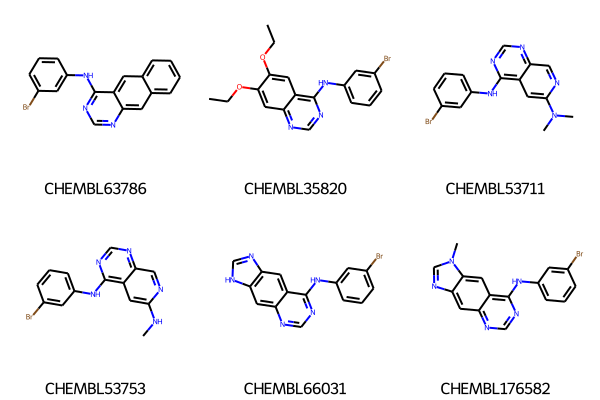

In [ ]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(egfr_data.head(6).ROMol),
    legends=list(egfr_data.head(6).molecule_chembl_id),
)

**Filter for PAINS**

The PAINS filter is already implemented in RDKit (documentation). Such pre-defined filters can be applied via the FilterCatalog class. Let's learn how it can be used.

In [ ]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [ ]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/4675 [00:00<?, ?it/s]

In [ ]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")

Number of compounds with PAINS: 409
Number of compounds without PAINS: 4266


**Let's have a look at the first 3 identified PAINS.**

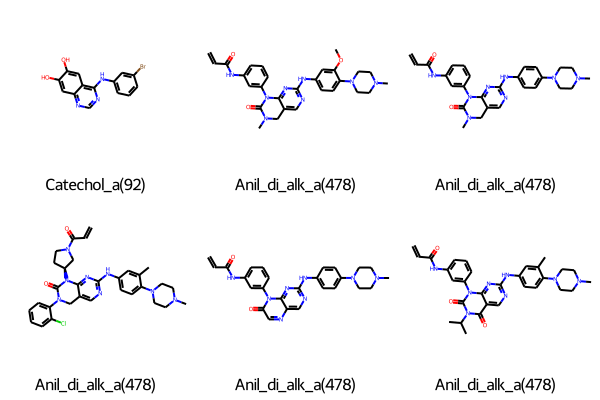

In [ ]:
Chem.Draw.MolsToGridImage(
    list(matches.head(6).rdkit_molecule),
    legends=list(matches.head(6)["pains"]),
)

**Filter and highlight unwanted substructures**

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually. Here, we use the list provided in the toxic_alert_smarts_??? code.

In [ ]:
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))

Saving toxic_alert_smarts.csv to toxic_alert_smarts.csv
Uploaded files: ['toxic_alert_smarts.csv']


In [ ]:
substructures = pd.read_csv("toxic_alert_smarts.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 109


**Search our filtered dataframe for matches with these unwanted substructures.**

In [ ]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]

  0%|          | 0/4266 [00:00<?, ?it/s]

In [ ]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")

Number of found unwanted substructure: 147
Number of compounds without unwanted substructure: 4183
